In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [2]:
def load_data(directory):
    images = []
    labels = []
    class_names = os.listdir(directory)
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            images.append(img)
            labels.append(class_name)
    return np.array(images), np.array(labels)

In [3]:
data_directory = "E:\\win_old\\uni\\4_Diploma\\dataset_normal" #директория
X, y = load_data(data_directory)

In [4]:
# разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# уменьшение размера обучающего набора данных
num_train_samples = min(500, X_train.shape[0])  #желаемое количество обучающих образцов (<~525)
np.random.seed(5)
random_indices = np.random.choice(X_train.shape[0], num_train_samples, replace=False)
print(random_indices)
X_train_subset = X_train[random_indices]
y_train_subset = y_train[random_indices]

# нормализация данных (приведение к диапазону от 0 до 1)
X_train_subset = X_train_subset.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# преобразование строковых меток в уникальные целочисленные значения
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_subset)
y_test_encoded = label_encoder.transform(y_test)

# кодирование меток (one-hot encoding)
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)
num_classes = len(label_encoder.classes_)

# проверка размеров полученных выборок
print("Размер обучающей выборки:", X_train_subset.shape)
print("Размер тестовой выборки:", X_test.shape)
print("Размер обучающей выборки меток:", y_train_encoded.shape)
print("Размер тестовой выборки меток:", y_test_encoded.shape)

[138 285  53 300  52 404 191 342 132 168 281 247 199 381 153  66 317  75
 282  21 251 213 328 275  99 222  43 108 343 240 248 344 393  98 390 209
 293 416 302 155 182   9 123 141 150  50 195 327 161 402  71 372 219 321
 185  49 157  47 279 296 368 117 358 151 229  62 127 421 339 237  90 322
 295 242 107 307 272 316   0  60 269 335 122 292 224 259 115 313 101 387
  55 170 333 201 347 129 412  48 252 312  42  26 140  56  88 250 331 226
 348  12 352 354 417 212 139  76 388  89 350 286  18  24  33 283 176 261
 422 273   6  10 149 152  81 360 238 244 218 234 336 221  83  92  45 353
  46 246 198  15 280  58 407 297  59 376  39 365  25 230  84  61  51 337
 320 186  11  17  67 277 414  96  68 106   4 424 102 184 379 227 395 383
 410 415 134  93 159 374 346 241  37 119 124 163 211 111 249 166 334   2
  95 131  23   3 363 305 403  28 351 223 133 298 299 373 142 409 288 156
 263 236 396 145 291 359  85 154 174 290 116 181  79 197  74  40 367 382
 423 162 408 128 329  20 306   1 378 278 397 253 26

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import Input

In [6]:
# создание модели нейронной сети
model = Sequential()

# сверточный слой с 32 фильтрами и размером ядра 3x3, функция активации ReLU
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1080, 1080, 3)))
# слой объединения для уменьшения размерности изображений
model.add(MaxPooling2D((2, 2)))

# добавление еще одного сверточного слоя
model.add(Conv2D(64, (3, 3), activation='relu'))
# добавление слоя объединения
model.add(MaxPooling2D((2, 2)))

# преобразование матрицы признаков в одномерный вектор
model.add(Flatten())

# полносвязный слой с 64 нейронами
model.add(Dense(64, activation='relu'))
# слой Dropout для регуляризации
model.add(Dropout(0.5))

# выходной слой с количеством нейронов, равным количеству классов (4) и функцией активации softmax
model.add(Dense(4, activation='softmax'))

# компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# вывод архитектуры модели
model.summary()

# определение параметров обучения
epochs = 15
batch_size = 10

# определение обратных вызовов
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

# обучение модели
history = model.fit(X_train_subset, y_train_encoded, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test_encoded), callbacks=[checkpoint, early_stopping, reduce_lr])

# оценка модели
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print("Тестовые потери:", score[0])
print("Тестовая точность:", score[1])

C:\Users\Max10\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1078, 1078, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 539, 539, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 537, 537, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 268, 268, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4596736)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │     294,191,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,210,820 (1.10 GB)

 Trainable params: 294,210,820 (1.10 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3278 - loss: 25.1401
Epoch 1: val_accuracy improved from -inf to 0.78505, saving model to best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 265s 6s/step - accuracy: 0.3300 - loss: 24.7940 - val_accuracy: 0.7850 - val_loss: 0.6405 - learning_rate: 0.0010
Epoch 2/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7308 - loss: 0.7785
Epoch 2: val_accuracy improved from 0.78505 to 0.85047, saving model to best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step - accuracy: 0.7314 - loss: 0.7778 - val_accuracy: 0.8505 - val_loss: 0.4429 - learning_rate: 0.0010
Epoch 3/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8100 - loss: 0.6138
Epoch 3: val_accuracy improved from 0.85047 to 0.91589, saving model to best_model.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - accuracy: 0.8103 - loss: 0.6115 - val_accuracy: 0.9159 - val_loss: 0.2717 - learning_rate: 0.0010
Epoch 4/15
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.88

KeyboardInterrupt: 

In [7]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

NameError: name 'history' is not defined

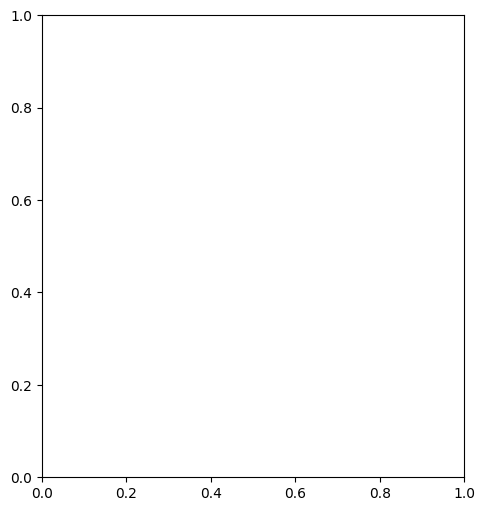

In [8]:
# визуализация процесса обучения
plt.figure(figsize=(12, 6))

# график функции потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на обучении и валидации')
plt.legend()

# график точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Потери на обучении и валидации')
plt.legend()

plt.show()

In [1]:
import cv2
import numpy as np
from keras.models import load_model

#model = load_model("best_model.keras")

def classify_image(image_path, model):
    # загрузка изображения
    img = cv2.imread(image_path)
    # классификация изображения с помощью модели
    predictions = model.predict(np.expand_dims(img, axis=0))
    
    # вывод
    class_labels = ["0green", "1yellow", "2red", "3black"]
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_labels[predicted_class_index]
    confidence = predictions[0][predicted_class_index]
    
    return predicted_class, confidence
    
# пример использования
image_path = "E:\\win_old\\uni\\4_Diploma\\data\\test (1).jpg"
predicted_class, confidence = classify_image(image_path, model)
print("Предсказанный класс:", predicted_class)
print("Confidence:", confidence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Предсказанный класс: 0green
Confidence: 1.0


In [13]:
image_path = "E:\\win_old\\uni\\4_Diploma\\data\\test (2).jpg"
predicted_class, confidence = classify_image(image_path, model)
print("Предсказанный класс:", predicted_class)
print("Confidence:", confidence)

NameError: name 'classify_image' is not defined

In [14]:
image_path = "E:\\win_old\\uni\\4_Diploma\\data\\test (3).jpg"
predicted_class, confidence = classify_image(image_path, model)
print("Предсказанный класс:", predicted_class)
print("Confidence:", confidence)

NameError: name 'classify_image' is not defined

In [15]:
image_path = "E:\\win_old\\uni\\4_Diploma\\data\\test (4).jpg"
predicted_class, confidence = classify_image(image_path, model)
print("Предсказанный класс:", predicted_class)
print("Confidence:", confidence)

NameError: name 'classify_image' is not defined

In [16]:
image_path = "E:\\win_old\\uni\\4_Diploma\\data\\test5.jpg"
predicted_class, confidence = classify_image(image_path, model)
print("Предсказанный класс:", predicted_class)
print("Confidence:", confidence)

NameError: name 'classify_image' is not defined

In [ ]:
image_path = "E:\\win_old\\uni\\4_Diploma\\data\\9r.png"
predicted_class, confidence = classify_image(image_path, model)
print("Предсказанный класс:", predicted_class)
print("Confidence:", confidence)